# Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/data/*.zip .
!unzip /content/sudoku.zip
!mkdir /content/test
!unzip /content/sudoku_test.zip -d /content/test
!mv /content/test/sudoku.csv /content/sudoku_test.csv

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/sudoku.zip
  inflating: sudoku.csv              
Archive:  /content/sudoku_test.zip
  inflating: /content/test/sudoku.csv  


In [2]:
!rm -rf drl-sudoku
!git clone https://github.com/cloughurd/drl-sudoku.git
!mv drl-sudoku/data/* .

Cloning into 'drl-sudoku'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 202 (delta 126), reused 72 (delta 34), pack-reused 0
Receiving objects: 100% (202/202), 322.66 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import gc
import math
import contextlib
from typing import List, Tuple
from tqdm import tqdm
import random
from model_util import stacked_to_mono, count_params

from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

# Create dataloader

In [0]:
from dataloader import *

# Define Model

In [0]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

In [0]:
class ToSudokuRange(nn.Module):
  def __init__(self):
    super(ToSudokuRange, self).__init__()
    self.sigmoid = nn.Sigmoid()
    self.net = lambda x: (9 * self.sigmoid(x)) + 0.5
  
  def forward(self, x):
    return self.net(x)

In [0]:
class SolverLayer(nn.Module):
  def __init__(self, in_filters:int, hidden_filters:int, out_filters:int, convtranspose:bool=True):
    super(SolverLayer, self).__init__()

    if in_filters != out_filters:
      self.skip = nn.Conv2d(in_filters, out_filters, kernel_size=1)
    else:
      self.skip = nn.Identity()

    self.initial_normalization = nn.InstanceNorm2d(in_filters) # Normalize every individual game within its filters. Not positive this is a good idea... maybe use the 3d version?

    self.HorizontalDependencies = self._get_dependency_module(in_filters, hidden_filters, (9,1), convtranspose=convtranspose)
    self.VerticalDependencies = self._get_dependency_module(in_filters, hidden_filters, (1,9), convtranspose=convtranspose)
    self.QuadrantDependencies = self._get_dependency_module(in_filters, hidden_filters, (3, 3), stride=3, convtranspose=convtranspose)

    num_hidden = hidden_filters * 3
    
    self.Reduce = nn.Sequential(
        nn.Conv2d(num_hidden, num_hidden, kernel_size=(3, 3), padding=1),
        nn.Conv2d(num_hidden, out_filters, kernel_size=(1, 1)), # Look at each cell only, without neighbors; neighbors have already been considered.
        nn.LeakyReLU()
    )

    self.Final = nn.LeakyReLU()

  def forward(self, x):
    skip = self.skip(x)
    x = self.initial_normalization(x)
    horizontal_result = self.HorizontalDependencies(x)
    vertical_result = self.VerticalDependencies(x)
    quadrant_result = self.QuadrantDependencies(x)

    combined = torch.cat((horizontal_result, vertical_result, quadrant_result), dim=1)

    reduced = self.Reduce(combined)

    residualized = reduced + skip
    return self.Final(residualized)

  def _get_dependency_module(self, in_filters, hidden_filters, kernel_size, stride=None, convtranspose=False):
    if stride is None:
      stride = 1
      
    if convtranspose:
        return nn.Sequential(
          nn.Conv2d(in_filters, hidden_filters*9, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(hidden_filters*9),
          nn.LeakyReLU(),
          nn.ConvTranspose2d(hidden_filters*9, hidden_filters, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(hidden_filters),
          nn.Dropout(),
          nn.LeakyReLU()
      )
    else:
      return nn.Sequential(
          nn.Conv2d(in_filters, hidden_filters, kernel_size=kernel_size, stride=stride),
          nn.BatchNorm2d(hidden_filters),
          nn.LeakyReLU(),
          Reshape((-1, hidden_filters, 9)),
          # Make into a full board shape that can be recombined... Maybe?
          nn.Linear(9, 81), 
          nn.BatchNorm1d(hidden_filters),
          nn.Dropout(),
          Reshape((-1, hidden_filters, 9, 9)),
          nn.LeakyReLU()
      )
    


In [0]:
class MonoModel(nn.Module):
  def __init__(self, solver_depth:int, convtranspose:bool=True, use_to_sudoku_range=True, growth_rate:Tuple[int]=(3,9)):
    super(MonoModel, self).__init__()
    if type(growth_rate) == int:
      growth_base = 3
      growth_frequency = growth_rate
    else:
      growth_base, growth_frequency = growth_rate
    layer_numbers = [(growth_base**(i // growth_frequency + 2), growth_base**( (i+1) // growth_frequency + 2)) for i in range(solver_depth - 2)]
    print(layer_numbers)
    reducer_layer = layer_numbers[-1][1]
    self.net = nn.Sequential(
        SolverLayer(1, 9, 9, convtranspose=convtranspose),
        *[ SolverLayer(i, i, o, convtranspose=convtranspose) for i, o in layer_numbers],
        SolverLayer(reducer_layer, reducer_layer, 1, convtranspose=convtranspose),
        Reshape((-1, 1, 9, 9)),
        ToSudokuRange() if use_to_sudoku_range else nn.Identity()
    )

  def forward(self, x):
    return self.net(x)

In [0]:
class StackedModel(nn.Module):
  def __init__(self, solver_depth:int, convtranspose:bool=True, growth_rate:Tuple[int]=(3,9)):
    super(StackedModel, self).__init__()
    if type(growth_rate) == int:
      growth_base = 3
      growth_frequency = growth_rate
    else:
      growth_base, growth_frequency = growth_rate
    layer_numbers = [(growth_base**(i // growth_frequency + 2), growth_base**( (i+1) // growth_frequency + 2)) for i in range(solver_depth - 1)]
    print(layer_numbers)
    reducer_layer = layer_numbers[-1][1]
    self.net = nn.Sequential(
        *[ SolverLayer(i, i, o, convtranspose=convtranspose) for i, o in layer_numbers],
        SolverLayer(reducer_layer, reducer_layer, 9, convtranspose=convtranspose),
    )

  def forward(self, x):
    return self.net(x)

In [0]:
def puzzle_exactifier(p):
  return torch.round(p)



def puzzle_masker(attempts, starting_puzzles):
  assert attempts.size() == starting_puzzles.size()
  num_filled_in_solution = torch.sum(starting_puzzles != 0).item()
  attempts = torch.where(starting_puzzles == 0, attempts, starting_puzzles)
  return (attempts, starting_puzzles, num_filled_in_solution)

def solved_accuracy(attempts, solutions, starting_puzzles):
  # print(f"Puzzle Acc Before if {attempts.size()} | {solutions.size()} | {starting_puzzles.size()}")
  if len(attempts.size()) == 4 and attempts.size(1) == 9:
    attempts = stacked_to_mono(attempts).squeeze(1)
    starting_puzzles = stacked_to_mono(starting_puzzles).squeeze(1)
    solutions = solutions + 1
  # print(f"After if {attempts.size()} | {solutions.size()} | {starting_puzzles.size()}")
  assert attempts.size() == solutions.size()
  masked_puzzle, _, _ = puzzle_masker(attempts, starting_puzzles)
  # print(masked_puzzle, solutions, starting_puzzles)
  num_puzzles = attempts.size(0)
  num_correct = (masked_puzzle.eq(solutions).sum(1).sum(1) == 9).sum().item()
  # if num_correct > 0:
    # print("\n-Masked - \n", masked_puzzle, "\n- Solutions -\n", solutions)
  return num_correct / num_puzzles

def cell_accuracy(attempts, solutions, starting_puzzles):
  # print(f"Cell Acc Before if {attempts.size()} | {solutions.size()} | {starting_puzzles.size()}")
  if len(attempts.size()) == 4 and attempts.size(1) == 9:
    attempts = stacked_to_mono(attempts)
    starting_puzzles = stacked_to_mono(starting_puzzles)
    solutions = solutions + 1
  # print(f"After if {attempts.size()} | {solutions.size()} | {starting_puzzles.size()}")
  assert attempts.size() == solutions.size()
  masked_puzzle, _, num_filled = puzzle_masker(attempts, starting_puzzles)
  print("\nAttempts:\n", attempts, "\nMasked\n", masked_puzzle, "\nInitial\n", starting_puzzles, "\nSolution\n", solutions)
  num_cells = attempts.numel()
  print(f"Comparison: \n{masked_puzzle.eq(solutions)}")
  num_correct = masked_puzzle.eq(solutions).sum().item()
  num_guessed_correctly = num_correct - num_filled
  num_to_guess = num_cells - num_filled
  # print(f"--- {num_cells} - {num_correct} - {num_cells} - {num_filled} ---")
  return num_guessed_correctly / num_to_guess


# Training Loop

In [0]:
def save_out(save_loc:str, model:MonoModel, **kargs):
  if save_loc is None:
    print("Skipping save, no save_loc provided.")
    return
  else:
    print(f"Saving to {save_loc}")
  state = {
      "model": model.state_dict()
  }

  for k, v in kargs.items():
    state[k]=v
  
  torch.save(state, save_loc)

def train(model:MonoModel,
          criterion:torch.nn.modules.loss._Loss,
          optimizer:torch.optim.Optimizer,
          train_loader:DataLoader,
          valid_loader:DataLoader,
          num_epochs:int,
          valid_frequency:int=5,
          save_interval:int=1000,
          mono=True,
          save_loc:str=None):
  loop = tqdm(total=num_epochs * len(train_loader) + (num_epochs // valid_frequency) * len(valid_loader), position=0)

  # The loss of the last training and validation iteration, respectively.  
  train_loss = None
  valid_loss = None

  # The puzzle accuracy of the last training and validation itersions. ( # puzzles right / # puzzles total )
  train_accuracy = None
  valid_accuracy = None

  # The cell accuracy of the last training and validation iterations ( # filled cells right / # num fillable cells )
  train_inner_acc = None
  valid_inner_acc = None

  tot_training_losses = []
  tot_training_accuracies = []
  tot_training_cell_accuracies = []

  for e in range(num_epochs):

    training_losses = []
    training_accuracies = []
    training_cell_accuracies = []

    loop.set_description(f"[Training] Epoch: {e}. Loss: {valid_loss}/{train_loss}. Total Accuracy: {train_accuracy}/{valid_accuracy}. Inner Accuracy: {train_inner_acc}/{valid_inner_acc}")

    for i, (puzzle, solution) in enumerate(train_loader):
      if mono:
        puzzle, solution = puzzle.float().cuda(async=False), (solution.float() + 1).cuda(async=False).unsqueeze(1)
      else:
        puzzle, solution = puzzle.float().cuda(async=False), solution.long().cuda(async=False)

      # print(f"\nPuzzle: {puzzle.size()}; solution: {solution.size()}")
      # initial_puzzle = puzzle.clone()

      optimizer.zero_grad()
      attempt = model(puzzle)

      if mono:
        loss = criterion(attempt, solution)
      else:
        solution_in = solution.view(-1, 81)
        attempt_in = attempt.view(-1, 9, 81)
        loss = criterion(attempt_in, solution_in)

      loss.backward()
      optimizer.step()

      train_loss = loss.item()
      training_losses.append(train_loss)

      # Compute accuracies
      exactified = puzzle_exactifier(attempt)

      solve_accuracy = solved_accuracy(exactified, solution, puzzle)
      c_acc = cell_accuracy(exactified, solution, puzzle)

      train_accuracy = solve_accuracy
      training_accuracies.append(train_accuracy)

      train_inner_acc = c_acc
      training_cell_accuracies.append(train_inner_acc)

      loop.set_description(f"[Training] Epoch: {e}. Loss: {valid_loss}/{train_loss}. Total Accuracy: {valid_accuracy}/{train_accuracy}. Inner Accuracy: {train_inner_acc}/{valid_inner_acc}")
      loop.update()

      if i % save_interval == 0:
        tmp_losses = tot_training_losses + [training_losses]
        tmp_game_accs = tot_training_accuracies + [training_accuracies]
        tmp_cell_accs = tot_training_cell_accuracies + [training_cell_accuracies]
        save_out(save_loc, model, train_loss=tmp_losses, train_game_accs=tmp_game_accs, train_cell_accs=tmp_cell_accs, epoch=e, iteration=i)
    tot_training_losses.append(training_losses)
    tot_training_accuracies.append(training_accuracies)
    tot_training_cell_accuracies.append(training_cell_accuracies)
    save_out(save_loc, model, train_loss=tot_training_losses, train_game_accs=tot_training_accuracies, train_cell_accs=tot_training_cell_accuracies, epoch=e, iteration=-1)
  return model, tot_training_losses, tot_training_accuracies, tot_training_cell_accuracies



In [0]:
model = MonoModel(solver_depth=5).cuda()
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
train_loader = get_loader(root="/content/", batch_size=3, mono=True, train=True, cap_train=5120)
valid_loader = []
num_epochs = 3

In [0]:
model = StackedModel(solver_depth=5).cuda()
train_loader = get_loader(root="/content/", batch_size=3, mono=False, train=True, cap_train=5120)
criterion = nn.CrossEntropyLoss()


[(9, 9), (9, 9), (9, 9), (9, 9)]


In [0]:
train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, 1, mono=True)

[Training] Epoch: 0. Loss: None/6.698751449584961. Total Accuracy: None/0.0. Inner Accuracy: 0.15966386554621848/None:   2%|▏         | 78/5121 [00:04<04:39, 18.06it/s]

KeyboardInterrupt: ignored

# Hyperparameter Experiments
* Things to test:
  * Total parameters;
  * depth of the network;
  * increase in filter banks; 
  * One-hot output vs. continuous.
  * Use sudoku range
  * ConvTranspose upsampling.

In [0]:
tests = {
    # "mono_sd_11_linear_sudoku_range": { "mono": True, "sd": 11, "convtranspose": False, "sudoku_range": True },
    # "mono_sd_11_convtran_sudoku_range": { "mono": True, "sd": 11, "convtranspose": True, "sudoku_range": True },
    # "mono_sd_11_convtran": { "mono": True, "sd": 11, "convtranspose": True, "sudoku_range": False },
    # "mono_sd_22_convtran": { "mono": True, "sd": 22, "convtranspose": True, "sudoku_range": False },
    # "stacked_sd_11_convtran": { "mono": False, "sd": 11, "convtranspose": True },
    # "stacked_sd_22_convtran": { "mono": False, "sd": 22, "convtranspose": True },
    # "stacked_sd_18_convtran": { "mono": False, "sd": 18, "convtranspose": True }
    # "stacked_sd_27_gr_3_26_convtran": { "mono": False, "sd": 27, "convtranspose": True, "growth_rate": (3, 26) },
    # "stacked_sd_81_gr_3_80_convtran": { "mono": False, "sd": 81, "convtranspose": True, "growth_rate": (3, 80) },
    "stacked_sd_11_gr_3_3_convtran": { "mono": False, "sd": 15, "convtranspose": True, "growth_rate": (3, 3) },


}

In [0]:
from os import path

def save_test(key, **kargs):
  f = "/content/gdrive/My Drive/data/models/hyper_experiment.pickle"
  if path.exists(f):
    existing = torch.load(f)
  else:
    existing = {}
  existing[key] = kargs
  torch.save(existing, f)

In [0]:
epochs = 3
cap_train = 1000000
batch_size = 256

for test in tests.keys():
  params = tests[test]
  mono = params["mono"]
  sd = params["sd"]
  convtranspose = params["convtranspose"]
  sudoku_range = params.get("sudoku_range")
  growth_rate = params.get("growth_rate")
  save_loc = f"/content/gdrive/My Drive/data/models/HyperExp/{test}.mod"


  if mono:
    model = MonoModel(solver_depth=sd, convtranspose=convtranspose, use_to_sudoku_range=sudoku_range, growth_rate=growth_rate).cuda()
    criterion = nn.MSELoss()
  else:
    model = StackedModel(solver_depth=sd, convtranspose=convtranspose, growth_rate=growth_rate).cuda()
    criterion = nn.CrossEntropyLoss()

  print(f"\nTesting model {test} with {count_params(model)} parameters.\n")
  train_loader = get_loader(root="/content/", batch_size=batch_size, mono=mono, train=True, cap_train=cap_train)
  optimizer = optim.Adam(model.parameters())
  valid_loader = []

  
  model, training_losses, game_accuracies, cell_accuracies = train(model,
                                                                   criterion,
                                                                   optimizer,
                                                                   train_loader=train_loader,
                                                                   valid_loader=valid_loader,
                                                                   num_epochs=epochs,
                                                                   valid_frequency=1,
                                                                   save_interval=1000,
                                                                   mono=mono,
                                                                   save_loc=save_loc)
  num_params = count_params(model)
  save_test(test, model=model.state_dict(), training_losses=training_losses, game_accuracies=game_accuracies, cell_accuracies=cell_accuracies, num_params=num_params)


[(9, 9), (9, 9), (9, 27), (27, 27), (27, 27), (27, 81), (81, 81), (81, 81), (81, 243), (243, 243), (243, 243), (243, 729), (729, 729), (729, 729)]


RuntimeError: ignored

In [0]:
count_params(model)

1640034

# Test Models

In [12]:
model = StackedModel(solver_depth=15, convtranspose=True, growth_rate=(3, 4)).cuda()
test = "stacked_sd_11_gr_3_4_convtran"
state = torch.load(f"/content/gdrive/My Drive/data/models/HyperExp/{test}.mod")
model.load_state_dict(state['model'])

[(9, 9), (9, 9), (9, 9), (9, 27), (27, 27), (27, 27), (27, 27), (27, 81), (81, 81), (81, 81), (81, 81), (81, 243), (243, 243), (243, 243)]


<All keys matched successfully>

In [0]:
dl = get_loader('/content/', train=False, mono=False, batch_size=256, cap_train=2560)

In [0]:
from display import *

In [96]:
tot = torch.zeros((9,9))
num_solved = 0
total_puzzles = 0
loop = tqdm(total=len(dl), position=0)
model = model.eval()
with torch.no_grad():
  for i, (puzzles, solutions) in zip(range(1009000), dl):
    # print(f"puzzles: {puzzles.size()}, Solutions: {solutions.size()}")
    puzzles, solutions = puzzles.float().cuda(), solutions.long().reshape(-1, 9,9)
    attempts = stacked_to_mono(model(puzzles)).reshape(-1, 9,9).cpu()
    # print(f"Attempts: {attempts.size()}, Solutions: {solutions.size()}")
    for attempt, solution in zip(attempts, solutions):
      total_puzzles += 1
      differences = attempt.eq(solution + 1).cpu().long()
      if differences.sum().item() == 81:
        # print(f"Solved puzzle: \n{attempt}\n{solution}\n")
        num_solved += 1
      # else:
        # print(f"Differend by {81 - differences.sum().item()}")
      # print(differences)
      tot += differences * -1 + 1
    loop.update(1)
    # print("----- Attempt -----")
    # print_tensor_puzzle(attempt.reshape(9,9,9))
    # print("----- Solution -----")
    # print(solution)
    # print(f"Cell Accuracy: {cell_accuracy(attempt, solution.cuda(), puzzle)}\nGAme Accuracy: {solved_accuracy(attempt, solution.cuda(), puzzle)}")
print(f"\nSolved {num_solved} / {total_puzzles}")
print(tot)

100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


Solved 808 / 2560
tensor([[64., 99., 61., 66., 65., 66., 61., 92., 91.],
        [51., 61., 58., 50., 46., 61., 63., 53., 51.],
        [64., 65., 57., 62., 61., 71., 45., 49., 61.],
        [73., 90., 77., 70., 84., 77., 57., 95., 71.],
        [51., 66., 54., 69., 45., 72., 62., 54., 76.],
        [58., 71., 56., 64., 35., 51., 54., 56., 66.],
        [53., 82., 53., 53., 81., 51., 56., 83., 56.],
        [48., 43., 57., 50., 50., 64., 38., 48., 63.],
        [69., 72., 63., 44., 54., 55., 52., 54., 65.]])


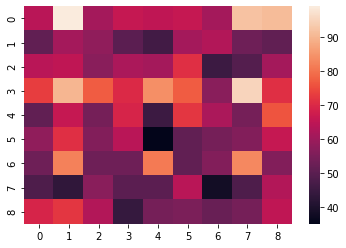

In [97]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(tot.view(9,9).numpy(), range(9), range(9))
sn.heatmap(df_cm) # font size
plt.show()

In [70]:
ones = torch.ones((3, 3))
mixed = torch.zeros((3,3))
mixed[:,1] = 1
ones.eq(mixed) * -1 + 1
ones.eq(mixed).sum()

tensor(3)

# TEST ACCURACY METRIC METHODS

In [0]:
j = torch.Tensor([[[1,1,1],[2,2,2],[3,3,3]],[[1,1,1],[2,2,2],[3,3,3]],[[1,1,1],[2,2,2],[3,3,3]]])
k = torch.Tensor([[[1,1,1],[2,2,2],[3,3,3]],[[1,1,1],[2,2,2],[3,3,3]],[[1,1,1],[2,2,2],[3,3,3]]])
l = torch.Tensor([[[2,2,2],[2,2,2],[3,3,3]],[[1,1,1],[2,2,2],[3,3,3]],[[1,1,1],[2,2,2],[3,3,3]]])

z = torch.zeros((3,3,3))
f = z.clone()
f[:,:,0] = k[:,:,0]
g = z.clone()
g[:,:,0] = l[:,:,0]

In [0]:
s = torch.load("/content/gdrive/My Drive/data/models/MonoModel.mod")

In [0]:
s

In [0]:
s.keys()


In [0]:
model.load_state_dict(s["model"])

In [0]:
train_loader = get_loader(root="/content/", batch_size=2, mono=True, train=True)

In [0]:
x, y = next(iter(train_loader))

In [0]:
y = y + 1

In [0]:
print(x, "\n", y)

In [0]:
print(puzzle_exactifier(model(x.float().cuda())), "\n", y)

In [0]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [0]:
params

In [0]:
model = MonoModel(solver_depth=21).cuda()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

In [0]:
ds = get_loader("/content/", mono=False, batch_size=1, cap_train=10)
dm = get_loader("/content/", mono=True, batch_size=1, cap_train=10)

In [0]:
xs, ys = next(iter(ds))
xm, ym = next(iter(dm))

In [0]:
y = y + 1
x,y = x.float().cuda(), y.float().cuda()

NameError: ignored

In [0]:
p = [dm.dataset.data.iloc[i].puzzle for i in range(10)]

In [0]:
p

['070000043040009610800634900094052000358460020000800530080070091902100005007040802',
 '301086504046521070500000001400800002080347900009050038004090200008734090007208103',
 '048301560360008090910670003020000935509010200670020010004002107090100008150834029',
 '008317000004205109000040070327160904901450000045700800030001060872604000416070080',
 '040890630000136820800740519000467052450020700267010000520003400010280970004050063',
 '561092730020780090900005046600000427010070003073000819035900670700103080000000050',
 '310450900072986143906010508639178020150090806004003700005731009701829350000645010',
 '800134902041096080005070010008605000406310009023040860500709000010080040000401006',
 '165293004000001632023060090009175000500900018002030049098000006000000950000429381',
 '000003610000015007000008090086000700030800100500120309005060904060900530403701008']

In [0]:
mp = torch.Tensor([dm.dataset.to_mono_grid(i) for i in p])

In [0]:
sp = torch.Tensor([dm.dataset.to_stacked_grid(i) for i in p])

In [0]:
sp = torch.Tensor(sp)
sp

In [0]:
sp.argmax(dim=1)

In [0]:
((sp.argmax(dim=0)) + 1)

In [0]:
mp

In [0]:
p

In [0]:
am = sp.argmax(dim=0)

In [0]:
am_mask = torch.all(sp == 0, dim=0)

In [0]:
am_mask

In [0]:
torch.where(am_mask, torch.zeros(am_mask.size()), am.float() + 1)

In [0]:
mp

In [0]:
from model_util import stacked_to_mono

In [0]:
stacked_to_mono(sp)

In [0]:
mp

In [0]:
sp[0]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         

In [0]:
mp[0]

tensor([[[0., 7., 0., 0., 0., 0., 0., 4., 3.],
         [0., 4., 0., 0., 0., 9., 6., 1., 0.],
         [8., 0., 0., 6., 3., 4., 9., 0., 0.],
         [0., 9., 4., 0., 5., 2., 0., 0., 0.],
         [3., 5., 8., 4., 6., 0., 0., 2., 0.],
         [0., 0., 0., 8., 0., 0., 5., 3., 0.],
         [0., 8., 0., 0., 7., 0., 0., 9., 1.],
         [9., 0., 2., 1., 0., 0., 0., 0., 5.],
         [0., 0., 7., 0., 4., 0., 8., 0., 2.]]])

In [0]:
stacked_to_mono(sp)[0]

tensor([[0., 7., 0., 0., 0., 0., 0., 4., 3.],
        [0., 4., 0., 0., 0., 9., 6., 1., 0.],
        [8., 0., 0., 6., 3., 4., 9., 0., 0.],
        [0., 9., 4., 0., 5., 2., 0., 0., 0.],
        [3., 5., 8., 4., 6., 0., 0., 2., 0.],
        [0., 0., 0., 8., 0., 0., 5., 3., 0.],
        [0., 8., 0., 0., 7., 0., 0., 9., 1.],
        [9., 0., 2., 1., 0., 0., 0., 0., 5.],
        [0., 0., 7., 0., 4., 0., 8., 0., 2.]], device='cuda:0')

In [0]:
def stacked_to_mono_old(puzzles):
    zeros_mask = torch.all(puzzles == 0, dim=1).cuda()
    maxes = puzzles.argmax(dim=1).cuda()
    return torch.where(zeros_mask, torch.zeros(zeros_mask.size()).cuda(), maxes.float().cuda() + 1).cuda().unsqueeze(1)

In [0]:
translated = stacked_to_mono(sp)

In [0]:
translated.shape

torch.Size([10, 9, 9])

In [0]:
mp.shape

torch.Size([10, 1, 9, 9])

In [0]:
translated.shape

torch.Size([10, 1, 9, 9])

In [0]:
torch.all(mp == translated)

tensor(True, device='cuda:0')